<a href="https://colab.research.google.com/github/sidharth-red/MCMC/blob/main/MCMC_Quadratic_data_Sidharth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U emcee
!pip install -U corner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 611.6 kB/s eta 0:00:00


In [2]:
import numpy as np
from abc import ABC, abstractmethod
import typing
from typing import Tuple
import matplotlib.pyplot as plt
from dataclasses import dataclass
import emcee
import corner

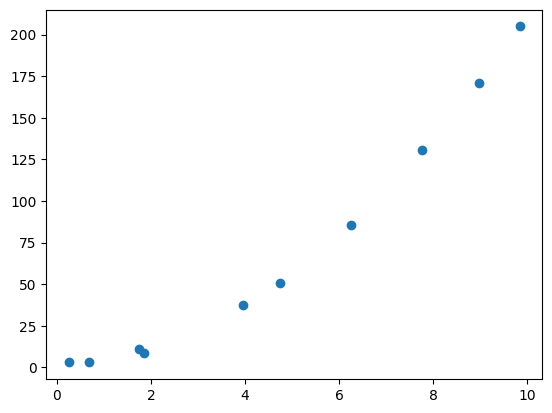

In [5]:
SEED = 42229
rng = np.random.default_rng(SEED)

@dataclass
class Points:
    x_points: np.ndarray
    y_points: np.ndarray
    num_points: int

    def plot(self):
        plt.scatter(self.x_points, self.y_points)

class TrueDataSource(ABC):
    @abstractmethod
    def generatePoints(self, num_points: int) -> Points:
        pass

class NoiseSource(ABC):
    @abstractmethod
    def applyNoise(self, points: Points) -> Points:
        pass

class DataSource(TrueDataSource):
    def __init__(self, a: float, b: float, c: float, x_max: float):
        self.a = a
        self.b = b
        self.c = c
        self.x_max = x_max

    def generatePoints(self, num_points: int) -> Points:
        x = np.sort(self.x_max * rng.random(num_points))
        y=self.a * x**2 + self.b*x +self.c
        return Points(x, y, num_points)

class GaussianNoiseSource(NoiseSource):
    def __init__(self, mean: float, std: float):
        self.mean = mean
        self.std = std

    def applyNoise(self, points: Points) -> Points:
        noisy_y = points.y_points + rng.normal(self.mean, self.std, points.num_points)
        return Points(points.x_points, noisy_y, points.num_points)

class NoisyDataSource():
    def __init__(self, true_source: TrueDataSource, noise_source: NoiseSource):
        self.true_source = true_source
        self.noise_source = noise_source

    def generatePoints(self, num_points: int) -> Points:
        true_points = self.true_source.generatePoints(num_points)
        noisy_points = self.noise_source.applyNoise(true_points)
        return noisy_points

# Example usage:
true_source = DataSource(a=2.0, b=1.0, c=2.0, x_max=10.0)
noise_source = GaussianNoiseSource(mean=0.0, std=1.0)
data_source = NoisyDataSource(true_source, noise_source)

points = data_source.generatePoints(10)
points.plot()
plt.show()


In [17]:
def model(theta, x_points):
    a, b, c = theta
    return ((a * x_points**2) + (b * x_points) +c)

def lnlike(theta, x, y, yerr):
    return -0.5 * np.sum(((y - model(theta, x))/yerr) ** 2)

def lnprior(theta):
    a, b, c = theta
    return 0.0
    # return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr) # really just lnlike(...), since lp == 0 if priors "satisfied". why priors have to be "satisfied"?

In [20]:
err = 1.0 # std of noise.
num_points = 1000
true_source = DataSource(a=2.0, b=1.0, c=1.0, x_max=10.0)
noise_source = GaussianNoiseSource(mean=0.0, std=err)
data_source = NoisyDataSource(true_source, noise_source)

points = data_source.generatePoints(num_points)
# points.plot()
# plt.show()

data = (points.x_points, points.y_points, err)
nwalkers = 128
niter = 500
initial = np.array([2.0, 1.0, 1.0])
ndim = len(initial)
nburnin = 100
nplottingsamples = 100
# p0 = [np.array(initial) + (1e-7 * np.random.randn(ndim)) for i in range(nwalkers)]
p0 = np.array(initial) + (1e-4 * np.random.randn(nwalkers, ndim))

def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)
    # print(p0)
    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    return sampler, pos, prob, state

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...
Running production...


100%|██████████| 500/500 [00:03<00:00, 153.71it/s]


In [21]:
def plotter(sampler, points):
    plt.ion()
    plt.scatter(points.x_points,points.y_points)
    samples = sampler.get_chain(flat=True, discard=nburnin)
    print(sampler.get_chain(flat=True).shape)
    for theta in samples[np.random.randint(len(samples), size=nplottingsamples)]:
        plt.plot(points.x_points, model(theta, points.x_points), color="r", alpha=0.1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('x_points')
    plt.ylabel('y_points')
    plt.legend()
    plt.show()
    labels = ['a', 'b', 'c']
    fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

(64000, 3)


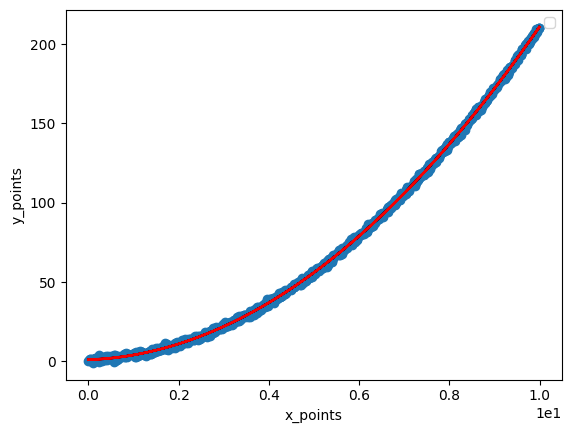

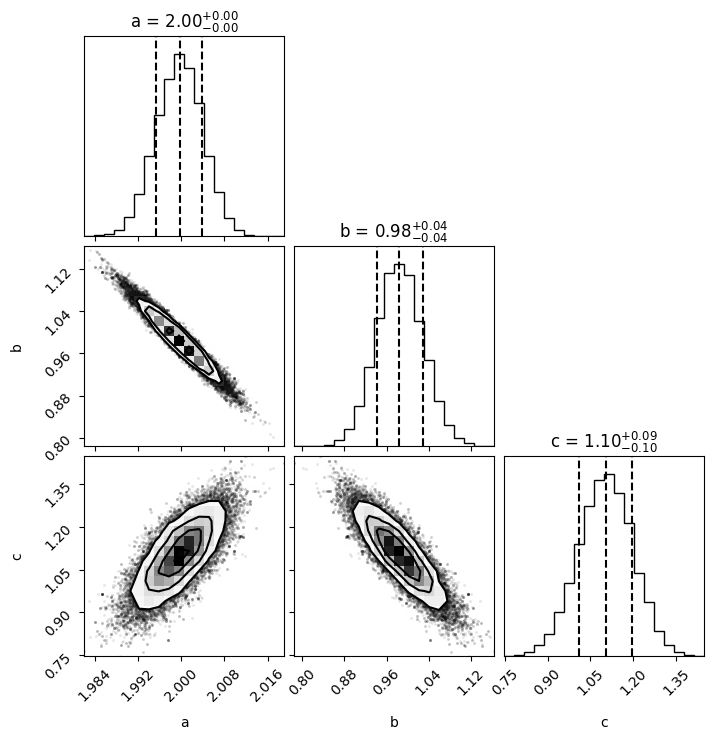

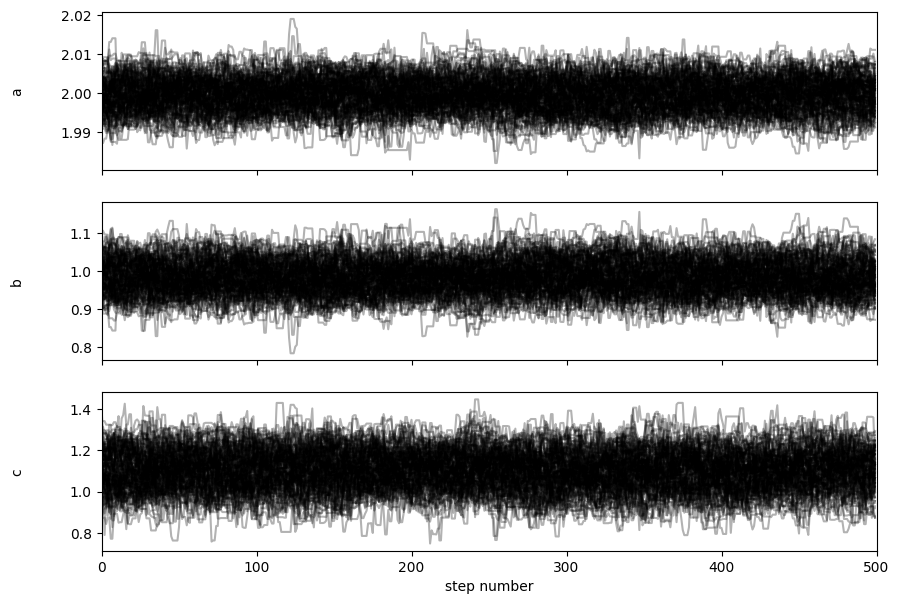

In [22]:
plotter(sampler, points)

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain() # shape = (niter, nwalkers, ndim)
labels = ["a", "b", "c"]
#print(f"ndim = {ndim}!!")
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");